# Evaluation Code

## Initialize MatKAN model

In [1]:
from MatrixKAN import *
from kan import KAN

torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=15)
np.set_printoptions(precision=15)

device = torch.device('cpu')

matkan_model = MatrixKAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)
kan_model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


## Dataset Preparation

```math
f(x, y) = e^{\sin{\pi x} + y^2}
```

In [2]:
from kan.utils import create_dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=1000, device=device)
print(dataset['train_input'].shape, dataset['train_label'].shape)

torch.Size([1000, 2]) torch.Size([1000, 1])


## Training

In [ ]:
matkan_model.fit(dataset, opt="LBFGS", steps=100, lamb=0.001);
kan_model.fit(dataset, opt="LBFGS", steps=100, lamb=0.001);

## Power Logging

The power usage of MacOS CPU is logged every 1 millisecond.

In [4]:
import os
import re
import csv
import signal
import subprocess
from contextlib import contextmanager

@contextmanager
def powermetrics_logger(log_file):
    """Context manager for powermetrics logging"""

    process = None
    try:
        cmd = [
            "sudo", "powermetrics",
            "--samplers", "matkan_power",
            "-i", "1",
            "-o", log_file
        ]
        process = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            preexec_fn=os.setsid
        )
        yield process
    finally:
        if process and process.poll() is None:
            os.killpg(os.getpgid(process.pid), signal.SIGTERM)
            process.wait()
            

def write2csv(log_file, output_file):
    """Extract all CPU power values from powermetrics log using regex."""
    matkan_power = []
    pattern = re.compile(r"CPU Power:\s*([0-9.]+)\s*mW")
    with open(log_file, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                matkan_power.append(match.group(1))
                
    """Append power data to CSV with a run identifier."""
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        for power in matkan_power:
            writer.writerow([power])

## Run Forward Pass on the First Layer

### MatrixKAN

In [5]:
import time

# Transform data to pass the first layer only
x = dataset['train_input'][:,matkan_model.input_id.long()]

log_file = "./log/matkan_power.log"
matkan_times = []
num_iter = 10000

with powermetrics_logger(log_file) as pm:
    if pm:
        with torch.no_grad():
            # Run forward pass of the first layer for "num_iter" times
            for _ in range(num_iter):
                start = time.time()
                matkan_out = matkan_model.act_fun[0].b_splines_matrix_output(x)
                end = time.time()
                matkan_times.append(end - start)

write2csv(
    log_file=log_file, 
    output_file="./log/matkan_power.csv"
)

## KAN

In [6]:
from kan.spline import coef2curve

x = dataset['train_input'][:,kan_model.input_id.long()]

log_file = "./log/kan_power.log"
kan_times = []
num_iter = 10000
                
with powermetrics_logger(log_file) as pm:
    if pm:
        with torch.no_grad():
            for _ in range(num_iter):
                start = time.time()
                kan_out = coef2curve(x, kan_model.act_fun[0].grid, kan_model.act_fun[0].coef, kan_model.act_fun[0].k)
                end = time.time()
                kan_times.append(end - start)

write2csv(
    log_file=log_file, 
    output_file="./log/kan_power.csv"
)

### Ours (FPGA)

In [7]:
MAX_INPUT = 1000
MAX_IN_NODE = 5
MAX_OUT_NODE = 5
GRID_SIZE = 10

x = dataset['train_input'][:,matkan_model.input_id.long()]

with torch.no_grad():
    # Pre-allocate all buffers avoid recreation
    _grid_buffer = np.zeros((MAX_IN_NODE, GRID_SIZE), dtype=np.float32)
    _grid_buffer = np.ascontiguousarray(_grid_buffer)
    _coef_buffer = np.zeros((MAX_IN_NODE, MAX_OUT_NODE, 6), dtype=np.float32)
    _coef_buffer = np.ascontiguousarray(_coef_buffer)
    _X_buffer = np.zeros((MAX_INPUT, MAX_IN_NODE), dtype=np.float32)
    _X_buffer = np.ascontiguousarray(_X_buffer)

    # Pre-compute sizes
    _grid_size = MAX_IN_NODE * GRID_SIZE
    _coef_size = MAX_IN_NODE * MAX_OUT_NODE * 6
    _X_size = MAX_INPUT * MAX_IN_NODE

    # Allocated input buffer to FPGA as 1D array to send as a stream
    _input_buffer = np.zeros(_grid_size + _coef_size + _X_size, dtype=np.float32)

    # Create memory views for each segment
    _grid_view = _input_buffer[:_grid_size]
    _coef_view = _input_buffer[_grid_size : _grid_size + _coef_size]
    _X_view = _input_buffer[_grid_size + _coef_size:]

    grid = matkan_model.act_fun[0].grid
    coef = matkan_model.act_fun[0].coef

    _grid_buffer[:grid.shape[0], :grid.shape[1]] = grid.cpu().numpy().astype(np.float32)
    _coef_buffer[:coef.shape[0], :coef.shape[1], :coef.shape[2]] = coef.cpu().numpy().astype(np.float32)
    _grid_view[:] = np.ravel(_grid_buffer)
    _coef_view[:] = np.ravel(_coef_buffer)

    valid_result = np.zeros((x.shape[0], coef.shape[0], coef.shape[1]), dtype=np.float64)

    _X_buffer.fill(0)  # Reset buffer
    _X_buffer[:, :x.shape[1]] = x[:, :].cpu().numpy().astype(np.float32)
    _X_view[:] = np.ravel(_X_buffer)

    # Send to FPGA
    # Use memoryview objects for zero-copy
    mv = memoryview(_input_buffer)
    matkan_model.act_fun[0].socket.send(mv)
    fpga_output = matkan_model.act_fun[0].socket.recv()

In [8]:
# Get the time taken of FPGA

# REP socket must first receive, then send
# REQ socket must first send, then receive

matkan_model.act_fun[0].socket.send(b"ACK")
raw_data = matkan_model.act_fun[0].socket.recv()
fpga_times = np.frombuffer(raw_data, dtype=np.float64)

In [9]:
fpga_output_numpy = np.frombuffer(fpga_output, dtype=np.float32).reshape((MAX_INPUT, MAX_IN_NODE, MAX_OUT_NODE))
valid_fpga_output_numpy = fpga_output_numpy[:, :2, :5].astype(np.float64)
np.max(np.abs(kan_out.cpu().numpy() - valid_fpga_output_numpy))

1.7913654552781377e-08

In [28]:
kan_diff = kan_out.cpu().numpy() - valid_fpga_output_numpy
matkan_diff = matkan_out.cpu().numpy() - valid_fpga_output_numpy
print("KAN:", np.mean(np.abs(kan_diff)), np.max(np.abs(kan_diff)))
print("MatrixKAN:", np.mean(np.abs(matkan_diff)), np.max(np.abs(matkan_diff)))
print("KAN MSE:", np.mean(kan_diff ** 2))
print("MatrixKAN MSE:", np.mean(matkan_diff ** 2))

KAN: 2.2942405628268188e-09 1.7913654552781377e-08
MatrixKAN: 2.302534947800236e-09 1.6493751024693193e-08
KAN MSE: 9.167435164353296e-18
MatrixKAN MSE: 9.379665307311835e-18


In [27]:
np.array([2, 2]) ** 2

array([4, 4])

## Throughput

Throughput is defined as the number of splines computed per second. In each forward pass through a layer, the number of splines computed are simply the product of each element in `y.shape` times the number of iteration (10000 is chosen).

In [24]:
num_splines = num_iter * np.prod(matkan_out.shape, dtype=np.float64)
matkan_tp = num_splines / sum(matkan_times)
kan_tp = num_splines / sum(kan_times)
fpga_tp = num_splines / sum(fpga_times)

clock_cycle = 30304.0
clock_speed = 100e6
fpga_time_no_dma = clock_cycle / clock_speed
fpga_tp_no_dma = np.prod(matkan_out.shape, dtype=np.float64) / fpga_time_no_dma

print(f"MatrixKAN's throughput is {matkan_tp} splines/second")
print(f"KAN's throughput is {kan_tp} splines/second")
print(f"FPGA + DMA's throughput is {fpga_tp} splines/second")
print(f"FPGA's throughput ignoring time taken in DMA is {fpga_tp_no_dma} splines/second")

MatrixKAN's throughput is 23144230.970850535 splines/second
KAN's throughput is 20857642.486434687 splines/second
FPGA + DMA's throughput is 6720355.219215349 splines/second
FPGA's throughput ignoring time taken in DMA is 32998944.033790916 splines/second


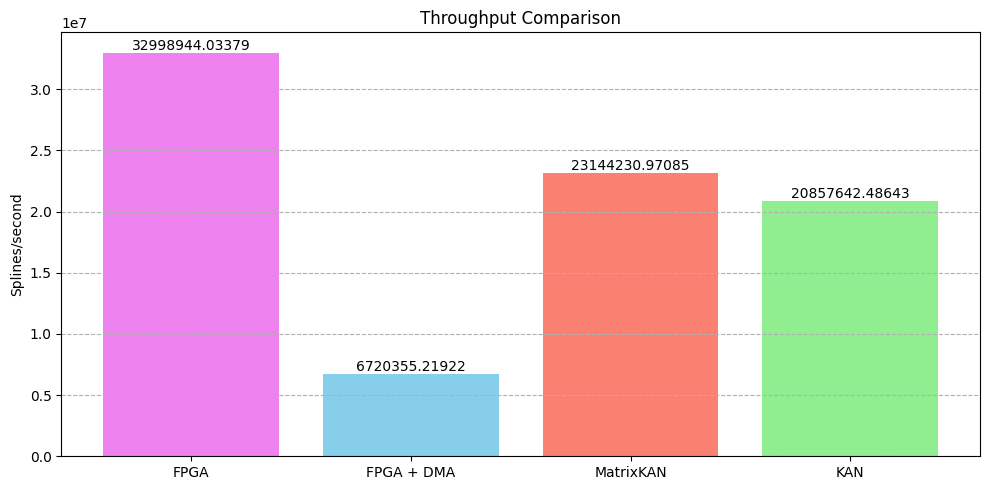

In [21]:
import matplotlib.pyplot as plt

models = ["FPGA", "FPGA + DMA", "MatrixKAN", "KAN"]
throughput = [fpga_tp_no_dma, fpga_tp, matkan_tp, kan_tp]

plt.figure(figsize=(10, 5))
bars = plt.bar(models, throughput, capsize=5, color=['violet', 'skyblue', 'salmon', 'lightgreen'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.5f}',  # Formats in scientific notation if too small
             ha='center', va='bottom')
plt.title(f"Throughput Comparison")
plt.ylabel("Splines/second")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

## Plot Time Taken Distribution of MatrixKAN

### Freedman-Diaconis

Compute number of bins for bar plot using Freedman-Diaconis rule. This is good for skewed data.

In [12]:
def fd_nbins(sorted_arr):
    q75, q25 = np.percentile(sorted_arr, [75, 25])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(sorted_arr) ** (1/3))
    n_bins = int((np.max(sorted_arr) - np.min(sorted_arr)) / bin_width)
    return n_bins

## Comparison of Inference Time

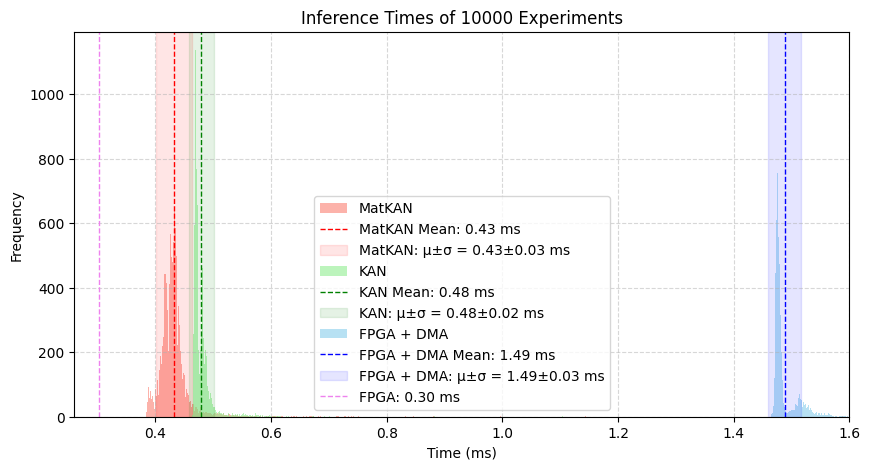

In [22]:
import matplotlib.pyplot as plt

sorted_matkan_times = np.sort(matkan_times) * 1000
sorted_kan_times = np.sort(kan_times) * 1000
sorted_fpga_times = np.sort(fpga_times) * 1000

mean_matkan = np.mean(sorted_matkan_times)
std_matkan = np.std(sorted_matkan_times)
max_matkan = np.max(sorted_matkan_times)

mean_kan = np.mean(sorted_kan_times)
std_kan = np.std(sorted_kan_times)
max_kan = np.max(sorted_kan_times)

mean_fpga = np.mean(sorted_fpga_times)
std_fpga = np.std(sorted_fpga_times)
max_fpga = np.max(sorted_fpga_times)

matkan_time_bins = fd_nbins(sorted_matkan_times)
kan_time_bins = fd_nbins(sorted_kan_times)
fpga_time_bins = fd_nbins(sorted_fpga_times)

plt.figure(figsize=(10, 5))

# MatrixKAN
plt.hist(sorted_matkan_times, bins=matkan_time_bins, alpha=0.6, label="MatKAN", color="salmon")
plt.axvline(mean_matkan, color='red', linestyle='--', linewidth=1.0, label=f'MatKAN Mean: {mean_matkan:.2f} ms')
plt.axvspan(mean_matkan - std_matkan, mean_matkan + std_matkan, color='red', alpha=0.1, label=f'MatKAN: μ±σ = {mean_matkan:.2f}±{std_matkan:.2f} ms')

# KAN
plt.hist(sorted_kan_times, bins=kan_time_bins, alpha=0.6, label="KAN", color="lightgreen")
plt.axvline(mean_kan, color='green', linestyle='--', linewidth=1.0, label=f'KAN Mean: {mean_kan:.2f} ms')
plt.axvspan(mean_kan - std_kan, mean_kan + std_kan, color='green', alpha=0.1, label=f'KAN: μ±σ = {mean_kan:.2f}±{std_kan:.2f} ms')

# FPGA + DMA
plt.hist(sorted_fpga_times, bins=fpga_time_bins, alpha=0.6, label="FPGA + DMA", color="skyblue")
plt.axvline(mean_fpga, color='blue', linestyle='--', linewidth=1.0, label=f'FPGA + DMA Mean: {mean_fpga:.2f} ms')
plt.axvspan(mean_fpga - std_fpga, mean_fpga + std_fpga, color='blue', alpha=0.1, label=f'FPGA + DMA: μ±σ = {mean_fpga:.2f}±{std_fpga:.2f} ms')

# FPGA (ignore DMA's time)
plt.axvline(fpga_time_no_dma * 1000, color='violet', linestyle='--', linewidth=1.0, label=f'FPGA: {fpga_time_no_dma * 1000:.2f} ms')

plt.xlabel("Time (ms)")
plt.ylabel("Frequency")
plt.title(f"Inference Times of {num_iter} Experiments")
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(0.26, 1.6)
plt.show()

### Total Time Taken for 10000 Forward Pass

In [23]:
print(f"Total time taken for MatrixKAN is {sum(matkan_times):.2f}s.")
print(f"Total time taken for KAN is {sum(kan_times):.2f}s.")
print(f"Total time taken for FPGA + DMA is {sum(fpga_times):.2f}s.")
print(f"Total time taken for FPGA ignoring DMA's time is {fpga_time_no_dma * num_iter:.2f}s.")

Total time taken for MatrixKAN is 4.32s.
Total time taken for KAN is 4.79s.
Total time taken for FPGA + DMA is 14.88s.
Total time taken for FPGA ignoring DMA's time is 3.03s.


## Power Consumption

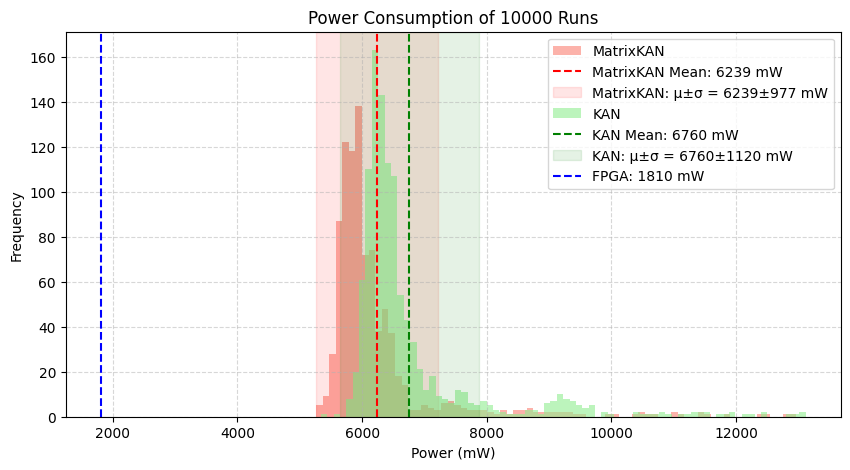

In [15]:
import pandas as pd

matkan_power = pd.read_csv("./log/matkan_power.csv", header=None)
kan_power = pd.read_csv("./log/kan_power.csv", header=None)
fpga_power = 1.81 * 1000 # Estimate from Vitis HLS

matkan_power = np.sort(matkan_power)
kan_power = np.sort(kan_power)

# Calculate statistics
matkan_mean_power = matkan_power.mean()
matkan_std_power = matkan_power.std()
kan_mean_power = kan_power.mean()
kan_std_power = kan_power.std()

# Freedman-Diaconis
matkan_power_bins = fd_nbins(matkan_power)
kan_power_bins = fd_nbins(kan_power)

plt.figure(figsize=(10, 5))

# MatrixKAN
plt.hist(matkan_power, bins=matkan_power_bins, alpha=0.6, label="MatrixKAN", color="salmon")
plt.axvline(matkan_mean_power, color='red', linestyle='--', linewidth=1.5, label=f'MatrixKAN Mean: {round(matkan_mean_power)} mW')
plt.axvspan(matkan_mean_power - matkan_std_power, matkan_mean_power + matkan_std_power, color='red', alpha=0.1, label=f'MatrixKAN: μ±σ = {round(matkan_mean_power)}±{round(matkan_std_power)} mW')

# KAN
plt.hist(kan_power, bins=kan_power_bins, alpha=0.6, label="KAN", color="lightgreen")
plt.axvline(kan_mean_power, color='green', linestyle='--', linewidth=1.5, label=f'KAN Mean: {round(kan_mean_power)} mW')
plt.axvspan(kan_mean_power - kan_std_power, kan_mean_power + kan_std_power, color='green', alpha=0.1, label=f'KAN: μ±σ = {round(kan_mean_power)}±{round(kan_std_power)} mW')

# Ours
plt.axvline(fpga_power, color='blue', linestyle='--', linewidth=1.5, label=f'FPGA: {round(fpga_power)} mW')

plt.xlabel("Power (mW)")
plt.ylabel("Frequency")
plt.title(f"Power Consumption of {num_iter} Runs")
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.show()

## Efficiency

Compute efficiency by the following formula

```math
\text{Efficiency (splines/sec/W)} = \frac{\text{Throughput (splines/sec)}}{\text{Mean Power (Watts)}}
```

In [16]:
matkan_eff = matkan_tp / (matkan_mean_power / 1000.0)
kan_eff = kan_tp / (kan_mean_power / 1000.0)
fpga_eff = fpga_tp / (fpga_power / 1000.0)
fpga_eff_no_dma = fpga_tp_no_dma / (fpga_power / 1000.0)

print(f"Efficiency of FPGA ignore time taken of DMA is {fpga_eff_no_dma:.2f} splines/s/W.")
print(f"Efficiency of FPGA is {fpga_eff:.2f} splines/s/W.")
print(f"Efficiency of MatrixKAN is {matkan_eff:.2f} splines/s/W.")
print(f"Efficiency of KAN is {kan_eff:.2f} splines/s/W.")

Efficiency of FPGA ignore time taken of DMA is 18231460.79 splines/s/W.
Efficiency of FPGA is 3712903.44 splines/s/W.
Efficiency of MatrixKAN is 3709645.24 splines/s/W.
Efficiency of KAN is 3085286.19 splines/s/W.


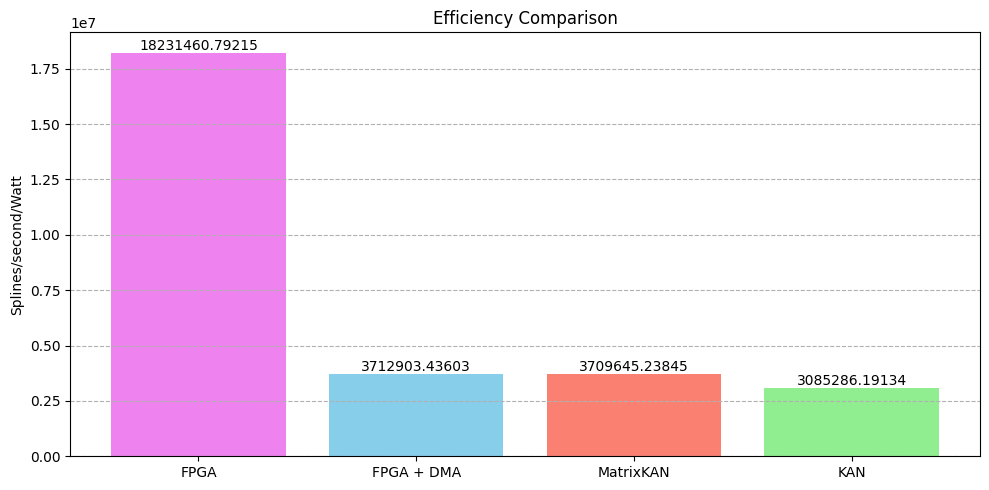

In [20]:
models = ["FPGA", "FPGA + DMA", "MatrixKAN", "KAN"]
efficiency = [fpga_eff_no_dma, fpga_eff, matkan_eff, kan_eff]

plt.figure(figsize=(10, 5))
bars = plt.bar(models, efficiency, capsize=5, color=['violet', 'skyblue', 'salmon', 'lightgreen'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.5f}',  # Formats in scientific notation if too small
             ha='center', va='bottom')
plt.title(f"Efficiency Comparison")
plt.ylabel("Splines/second/Watt")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

## Power Efficiency Improvement

```math
\text{Power Efficiency Improvement} = \frac{\text{FPGA Efficiency}}{\text{CPU Efficiency}}
```

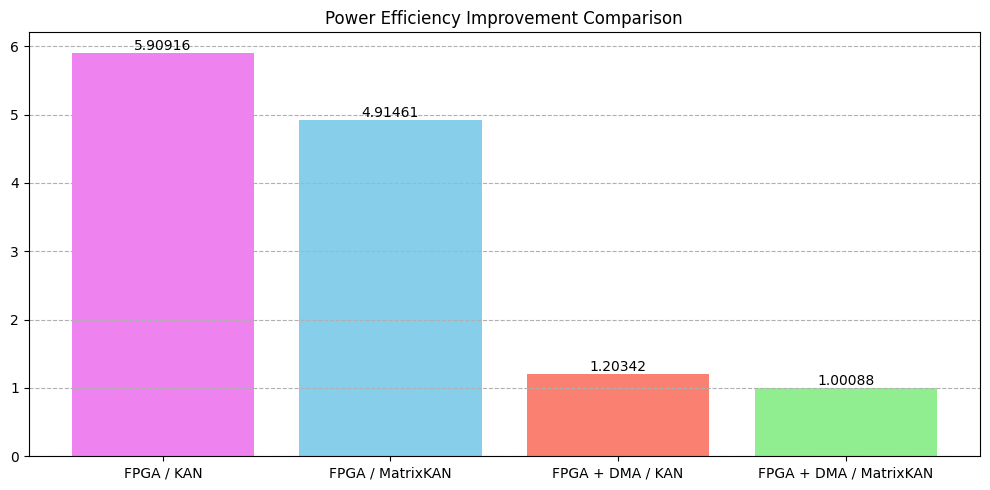

In [19]:
fpga_over_kan = fpga_eff / kan_eff
fpga_over_matkan = fpga_eff / matkan_eff
fpga_no_dma_over_kan = fpga_eff_no_dma / kan_eff
fpga_no_dma_over_matkan = fpga_eff_no_dma / matkan_eff

models = ["FPGA / KAN", "FPGA / MatrixKAN", "FPGA + DMA / KAN", "FPGA + DMA / MatrixKAN"]
improvement = [fpga_no_dma_over_kan, fpga_no_dma_over_matkan, fpga_over_kan, fpga_over_matkan]

plt.figure(figsize=(10, 5))
bars = plt.bar(models, improvement, capsize=5, color=['violet', 'skyblue', 'salmon', 'lightgreen'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.5f}',  # Formats in scientific notation if too small
             ha='center', va='bottom')
plt.title(f"Power Efficiency Improvement Comparison")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()